<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/15_Light_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Выполните задания, по каждому варианту напишите точность распознавания на проверочной выборке и сделайте выводы (тексты писателей).

А. Запустите нейронку c bag of words (01) при разных maxWordsCount

1. 100

2. 1000

3. 10000

4. 50000

*Если у Вас будет переполнение ОЗУ, можно написать “не хватает памяти” в ноутбуке

Б. Запустите нейронку c bag of words (01) при maxWordsCount = 10000 и разных архитектурах

1. Поменяйте количество нейронов в слоях

2. Поменяйте количество слоев

3. Поменяйте активационные функции слоев

В. Запустите нейронку c Embbedding при maxWordsCount = 10000, поменяйте размер Embedding пространства

1. 10

2. 50

3. 200

# Импорт библиотек

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer  #Метод для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences #Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder #Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split #Метод для разделения выборки на обучающую и тестовую

from google.colab import drive
import time #Импортируем библеиотеку time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
#Собираем данные через функцию, которая читает данные
#На вход подаем путь к файлу, открываем файл в режиме чтения
# переносы строки меняем на пробелы
# возвращаем текст файла
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')

  return text

def readText(fileName): 
  f = open(fileName, 'r')        
  text = f.read()           
  text = text.replace("\n", " ") 
  
  return text                    

# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов  

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample  

def plot_show():
    plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.show()


# Обработка текстов

In [ ]:

# Объявляем классы и считаем кол-во классов
className = ['О. Генри', 'Стругацкие', 'Булгаков', ' Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

#Загружаем обучающие тексты

trainText = []
testText = []

#Создаем выборку по условию:
#Класс каждого i-го элемента в обучающей выборке должен соответствовать
#классу каждого i-го элемента тестовой выборки

# Обходим классы
for i in className:
  # пробегаемся по всем документам в папке 'texts'
  for j in os.listdir('texts/'):
    # смотрим содержится ли в названии имя класса, если да , то работаем дальше
    if i in j:
      # Дальше проверяем обучающий это файл или тестовый и добавляем текст в выборку
      if 'Обучающая' in j:
        trainText.append(readText('texts/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/' + j))
        print(j, 'добвлен в тестовую выборку')
print()


(О. Генри) Тестовая_20 вместе.txt добвлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Клиффорд Саймак) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Клиффорд Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добвлен в тестовую выборку



In [ ]:
# Посмотрим кол-во элементов в trainText и в первом элементе 
print(len(trainText))
print(len(trainText[0]))

# Посмотрим кол-во элементов в testText и в первом элементе 
print(len(testText))
print(len(testText[0]))

6
1049517
6
349662


# maxWordsCount = 50000
Лучший результат = 89,10 %

In [ ]:
maxWordsCount = 50000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.17c


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

In [ ]:
print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words

(17640, 50000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]


In [ ]:

#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
# plot_show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                3200064   
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                

# maxWordsCount = 10 000
Лучший результат = 89,95%

In [ ]:
maxWordsCount =10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.22c


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dense_26 (Dense)             (None, 6)                

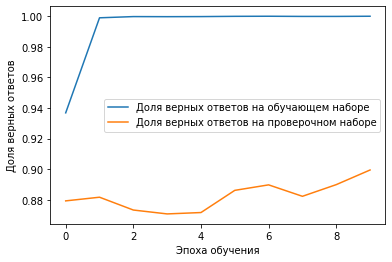

In [ ]:

#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

# maxWordsCount = 1000
Лучший результат = 89,64%

In [ ]:
maxWordsCount =10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.13c


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                

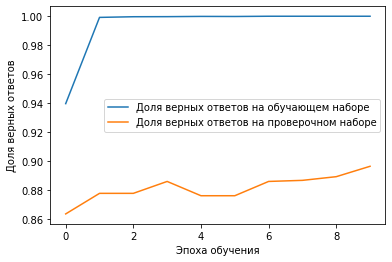

In [ ]:

#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

# maxWordsCount = 100
Лучший результат = 89,81%

In [ ]:
maxWordsCount =10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.11c


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
dense_32 (Dense)             (None, 6)               

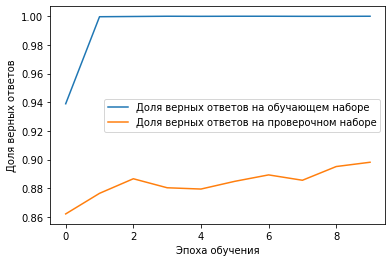

In [ ]:

#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

# Bag of words (01) при maxWordsCount = 10000 

In [ ]:
maxWordsCount =10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.03c


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

## 32 нейрона 2 слоя
Лучший результат = 88,08%

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
dense_35 (Dense)             (None, 6)               

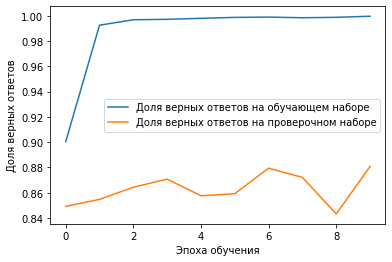

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 64 нейрона 2 слоя
Лучший результат = 88,21%

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 64)                256       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
dense_38 (Dense)             (None, 6)               

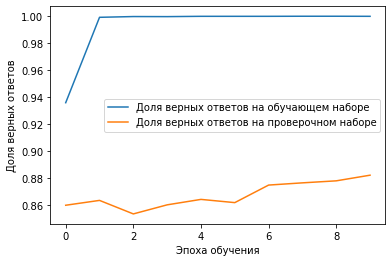

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 128 нейронов 2 слоя
Лучший результат = 89,01%

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_41 (Dense)             (None, 6)               

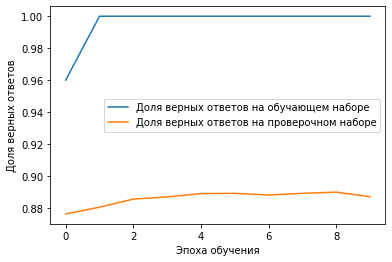

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(128, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(128, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 256 нейронов 2 слоя
Лучший результат = 88,96%

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
dense_44 (Dense)             (None, 6)               

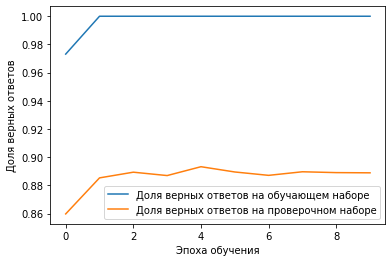

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(256, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(256, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 512 нейронов 2 слоя
Лучший результат = 86, 59%

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 512)               2048      
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
dense_50 (Dense)             (None, 6)               

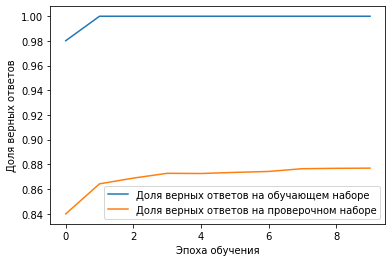

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(512, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(512, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 1024 нейрона 2 слоя
Лучший результат = 82,71%

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_55 (Dense)             (None, 10242)             10498050  
_________________________________________________________________
dropout_37 (Dropout)         (None, 10242)             0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 10242)             40968     
_________________________________________________________________
dense_56 (Dense)             (None, 6)               

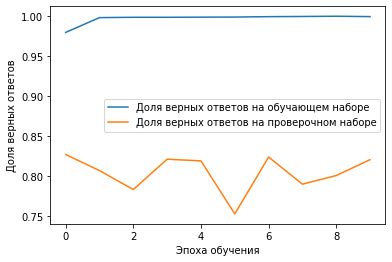

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(1024, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(10242, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 1 слой 32 нейрона
Лучший результат = 87,21%

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_58 (Dense)             (None, 6)                 3078      
Total params: 5,123,590
Trainable params: 5,123,590
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 1s 8ms/step - loss: 0.0703 - accuracy: 0.9788 - val_loss: 0.3794 - val_accuracy: 0.8630
Epoch 2/10
138/138 [==============================] - 1s 5ms/step - loss: 9.6397e-05 - accuracy: 1.0000 - val_loss: 0.3736 - val_accuracy: 0.8642
Epoch 3/10
138/138 [==============================] - 1s 5ms/step - loss: 5.7453e-05 - accuracy: 1.0000 - val_loss: 0.3668 - val_accuracy: 0.8661
Epoch 4/10
138/138 [==============================] - 1s 5ms/step - los

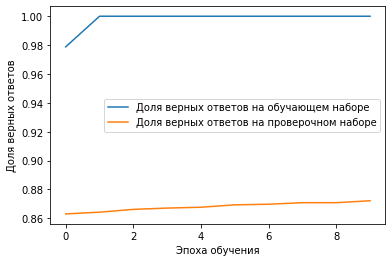

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()

#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(512, input_dim=maxWordsCount, activation="relu"))

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 2 слоя 32 нейрона
Лучший результат = 85.49%

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_67 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_68 (Dense)             (None, 6)                 198       
Total params: 321,286
Trainable params: 321,286
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 1s 7ms/step - loss: 0.2002 - accuracy: 0.9457 - val_loss: 0.5002 - val_accuracy: 0.8337
Epoch 2/10
138/138 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4674 - val_accuracy: 0.8364
Epoch 3/10
138/138 [==============================] - 1s 5ms/step - loss: 3.3071e-04 - accura

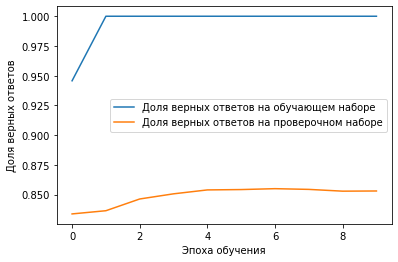

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()

#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))

model.add(Dense(32, activation="relu"))



#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 3 слоя 32 нейрона
Лучший результат = 89,65%

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_63 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_64 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_65 (Dense)             (None, 6)                 198       
Total params: 322,342
Trainable params: 322,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 1s 7ms/step - loss: 0.1789 - accuracy: 0.9478 - val_loss: 0.3958 - val_accuracy: 0.8702
Epoch 2/10
138/138 [==============================] - 1s 5ms/step - loss: 4.8679e-04 - accuracy: 1.0000

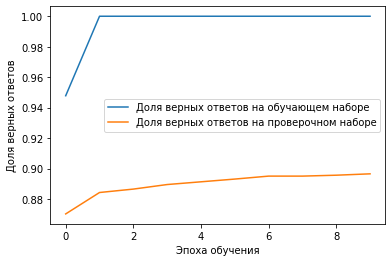

In [ ]:
# Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()

#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 4 слоя 32 нейрона
Лучший результат = 84,43%

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_75 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_76 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_77 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_78 (Dense)             (None, 6)                 198       
Total params: 323,398
Trainable params: 323,398
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 1s 7ms/step - loss: 0.2800 - accuracy: 0.9163 - val_loss: 0

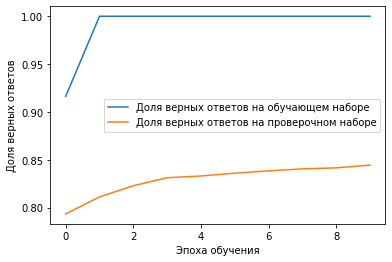

In [ ]:
# Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()

#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## 5 слоев 32 нейрона
Лучший результат = 85,78%

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_80 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_81 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_82 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_84 (Dense)             (None, 6)                 198       
Total params: 324,454
Trainable params: 324,454
Non-trainable params: 0
_______________________________________________

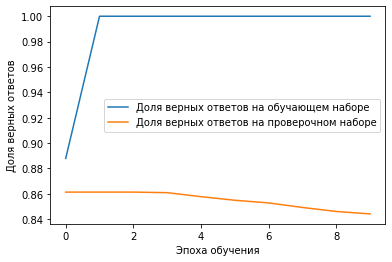

In [ ]:
# Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()

#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation="relu"))

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## ELU + Sigmoid
Лучший результат = 90,52%

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 32)                128       
_________________________________________________________________
dense_86 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dense_87 (Dense)             (None, 6)               

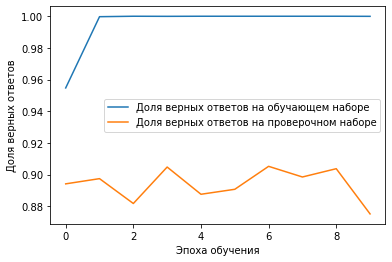

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="elu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="elu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## TANH + Sigmoid
Лучший результат = 88,99%

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 32)                128       
_________________________________________________________________
dense_89 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 32)                128       
_________________________________________________________________
dense_90 (Dense)             (None, 6)               

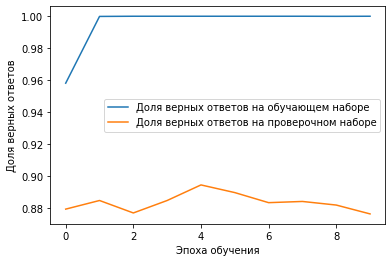

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="tanh"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="tanh"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

##RELU + Softmax
Лучший результат = 90,13%

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 32)                128       
_________________________________________________________________
dense_92 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
dense_93 (Dense)             (None, 6)               

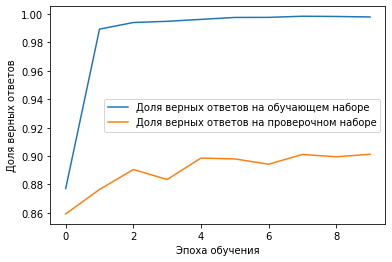

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

##LINEAR + Softmax
Лучший результат = 90,67%

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 32)                128       
_________________________________________________________________
dense_95 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_45 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 32)                128       
_________________________________________________________________
dense_96 (Dense)             (None, 6)               

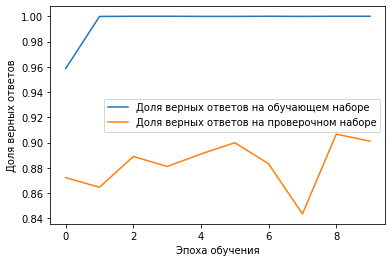

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

## LINEAR + Sigmoid
Лучший результат = 90,14%

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_46 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 32)                128       
_________________________________________________________________
dense_98 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
dense_99 (Dense)             (None, 6)               

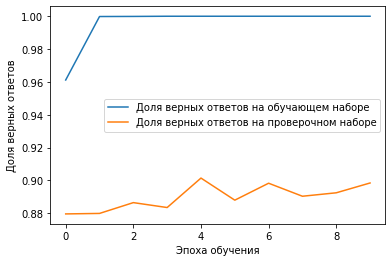

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
                       
# # Выводим график обучения
plot_show()

# Нейронка c Embbedding при maxWordsCount = 10000

In [ ]:
maxWordsCount =10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.24c


## Размер Embedding пространства = 10
Лучший результат = 78.52%

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 10)          100000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_125 (Dense)            (None, 32)                320032    
_________________________________________________________________
dropout_64 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 32)                128       
_________________________________________________________________
dense_126 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_65 (Dropout)         (None, 32)              

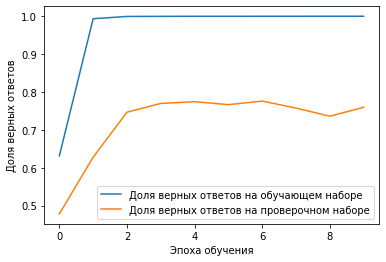

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
model.add(Embedding(maxWordsCount, 10, input_length=xLen))
model.add(Flatten())
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть 
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))
                       
# # Выводим график обучения
plot_show()

## Размер Embedding пространства = 50
Лучший результат = 81,44%

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                1600032   
_________________________________________________________________
dropout_60 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 32)                128       
_________________________________________________________________
dense_120 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_61 (Dropout)         (None, 32)              

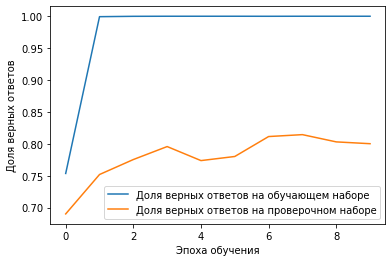

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
model.add(Embedding(maxWordsCount, 50, input_length=xLen))
model.add(Flatten())
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть 
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))
                       
# # Выводим график обучения
plot_show()

## Размер Embedding пространства = 200
Лучший результат = 82,78% 

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 200)         2000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 200000)            0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                6400032   
_________________________________________________________________
dropout_62 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 32)                128       
_________________________________________________________________
dense_123 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)              

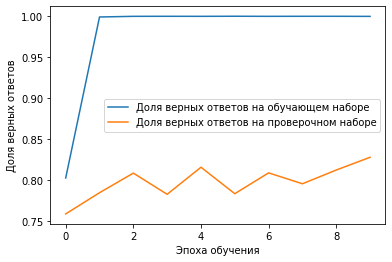

In [ ]:
#Создаём полносвязную сеть на 32 нейрона 2 слоя
model = Sequential()
model.add(Embedding(maxWordsCount, 200, input_length=xLen))
model.add(Flatten())
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(32, input_dim=maxWordsCount, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(32, activation="linear"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть 
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))
                       
# # Выводим график обучения
plot_show()

# Выводы

1.Увеличение количеств нейронов возможно до определенного предела , после которого результат точности падает. На небольших количествах нейронов можно получить вполне достойный результат (64, 128 нейронов в слое) 89,01%.
2.Тоже самое можно сказать и про количество слоев , успешными  вариантами были варианты с  1 и 3 Dense слоями, лучшая точность 89,65%.
3.В экспериментах  с функциями активации хорошо показали себя 2 варианта : ELU+Sigmoid = точность 90,52% и LINEAR+Softmax = точность 90,67%.
4.Обучение нейронки с помощью слоя Embedding не дал высоких результатов , но показал тенденцию увеличения точности на 1% при увеличении внутреннего слоя в 4 раза.
5.Оптимальным значением maxWordsCount оказалось 10 000. Размер словаря для данной задачи может быть небольшим, что позволит быстрее обучать нейронку и потребует меньше ресурсов colab. 

Резюме : всегда начинать с простых вариантов, большое преимущество дает метод bag of words , а также 1-2 % точности могут добавить эксперименты с функциями активации.

